In [1]:
# Check GPU availability and specs
!nvidia-smi

import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
  print(f"GPU name: {torch.cuda.get_device_name(0)}")
  print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Sat Jan 10 15:52:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Mount Drive
from google.colab import drive
import os

#Mount Drive
drive.mount('/content/drive')

#Dir. to project directory
project_dir = '/content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art'
os.makedirs(project_dir, exist_ok = True)
os.chdir(project_dir)

print(f"Working Directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory: /content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art


In [3]:
# Install dependencies (run in Colab)
!pip install diffusers transformers accelerate peft bitsandbytes
!pip install zenml mlflow datasets pillow

# Authenticate with Hugging Face
from huggingface_hub import notebook_login
notebook_login()

In [4]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from transformers import CLIPTextModel
import os
from pathlib import Path

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [5]:
class LoRATrainer:
    """Fine-tune Stable Diffusion XL with LoRA on Colab"""

    def __init__(self,
                 model_id="stabilityai/stable-diffusion-xl-base-1.0",
                 output_dir="./lora_weights",
                 concept_name="african_art"):
        self.model_id = model_id
        self.output_dir = output_dir
        self.concept_name = concept_name

    def setup_lora_layers(self, unet, rank=4):
        """Add LoRA layers to UNet attention processors"""
        lora_attn_procs = {}
        for name in unet.attn_processors.keys():
            cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]

            lora_attn_procs[name] = LoRAAttnProcessor(
                hidden_size=hidden_size,
                cross_attention_dim=cross_attention_dim,
                rank=rank
            )

        unet.set_attn_processor(lora_attn_procs)
        return lora_attn_procs

    def train(self, train_data_dir, num_epochs=100, learning_rate=1e-4):
        """
        Training logic using Diffusers trainer
        This is simplified - use diffusers' DreamBooth training script for production
        """
        from accelerate import Accelerator

        # Load base model
        pipe = StableDiffusionPipeline.from_pretrained(
            self.model_id,
            torch_dtype=torch.float16
        )

        # Setup LoRA
        unet = pipe.unet
        lora_layers = self.setup_lora_layers(unet, rank=4)

        # Training loop would go here
        # For POC, use diffusers' train_dreambooth_lora.py script

        print(f"Training on {train_data_dir} for {num_epochs} epochs...")
        print("Use: accelerate launch train_dreambooth_lora.py \\")
        print(f"  --pretrained_model_name_or_path={self.model_id} \\")
        print(f"  --instance_data_dir={train_data_dir} \\")
        print(f"  --output_dir={self.output_dir} \\")
        print(f"  --instance_prompt='a photo of {self.concept_name}' \\")
        print(f"  --resolution=512 \\")
        print(f"  --train_batch_size=1 \\")
        print(f"  --gradient_accumulation_steps=4 \\")
        print(f"  --learning_rate={learning_rate} \\")
        print(f"  --lr_scheduler='constant' \\")
        print(f"  --max_train_steps={num_epochs * 10} \\")
        print(f"  --use_8bit_adam")

### VERIFY TRAINING IMAGES

✓ Found 33 images
✓ Location: ./data/training_images/


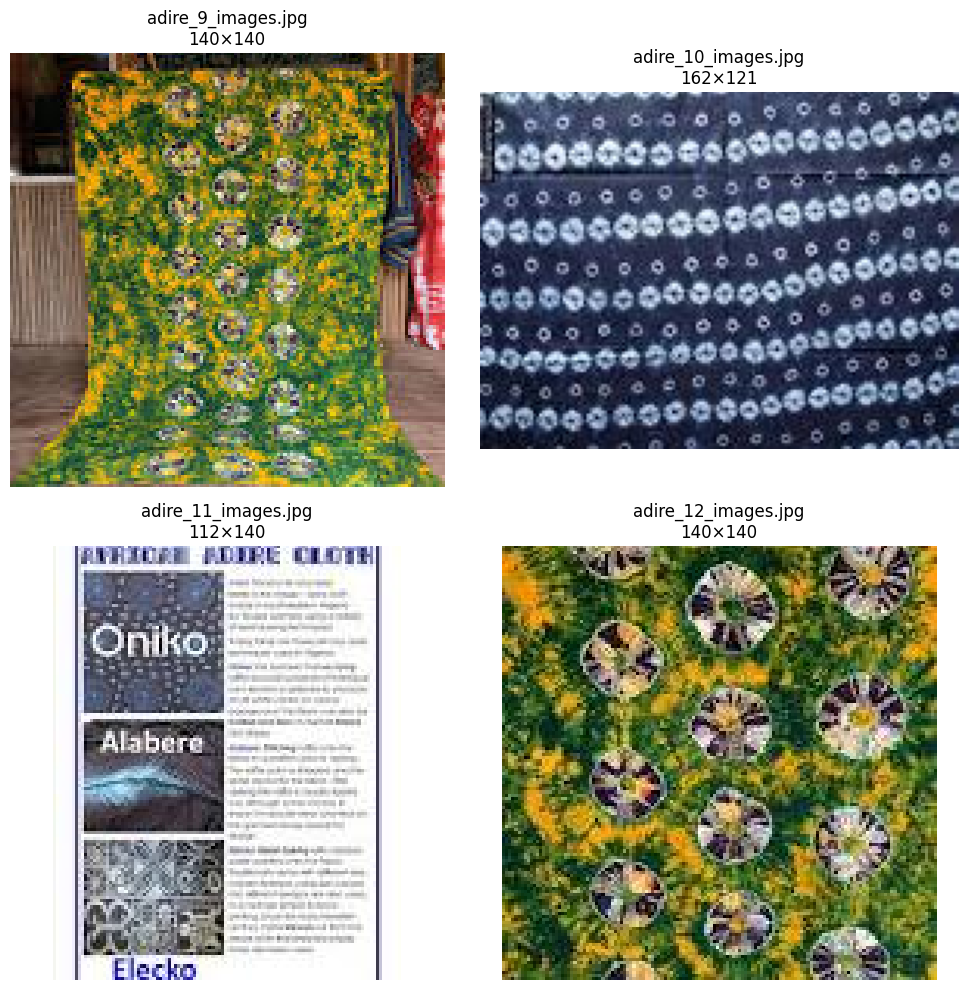


✓ Ready to train!


In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Check if images exist in Drive
training_dir = './data/training_images/'

if not os.path.exists(training_dir):
    print(f"❌ Directory not found: {training_dir}")
    print("Please create 'training_images' folder in your Drive and upload images")
else:
    # List all images
    image_files = [f for f in os.listdir(training_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"✓ Found {len(image_files)} images")
    print(f"✓ Location: {training_dir}")

    if len(image_files) < 15:
        print(f"\n⚠️  Warning: Only {len(image_files)} images. Recommend 20-30 for best results.")

    # Show first 4 images as preview
    if len(image_files) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes = axes.flatten()

        for idx in range(min(4, len(image_files))):
            img = Image.open(os.path.join(training_dir, image_files[idx]))
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f"{image_files[idx]}\n{img.size[0]}×{img.size[1]}")

        plt.tight_layout()
        plt.show()

        print("\n✓ Ready to train!")
    else:
        print("\n❌ No images found. Please upload images first.")

#### DOWNLOAD SDXL TRAINING SCRIPT

In [7]:
# Download the official SDXL LoRA training script
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

# Verify download
import os
if os.path.exists('train_dreambooth_lora_sdxl.py'):
    print("✓ Training script downloaded!")
    print(f"✓ Size: {os.path.getsize('train_dreambooth_lora_sdxl.py') / 1024:.1f} KB")
else:
    print("❌ Download failed. Try again.")

✓ Training script downloaded!
✓ Size: 84.7 KB


#### TRAINING CONFIGURATION

In [8]:
# Set your configuration
CONFIG = {
    # Model settings
    "model_name": "stabilityai/stable-diffusion-xl-base-1.0",
    "output_dir": "/content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/lora_weights",

    # Data settings
    "instance_data_dir": './data/training_images/',
    "instance_prompt": "a photo in nigerian_adire_style",  # ⚠️ CHANGE THIS to match your concept

    # Training parameters
    "resolution": 1024,  # SDXL native resolution
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "learning_rate": 1e-4,
    "max_train_steps": 800,  # ~75 minutes on T4

    # Validation
    "validation_prompt": "a nigerian_adire_style painting of Lagos cityscape at sunset",  # ⚠️ CHANGE THIS
    "validation_epochs": 100,  # Generate sample every 100 steps

    # Other
    "seed": 42,
    "checkpointing_steps": 100,  # Save checkpoint every 100 steps
}

In [9]:
# Create output directory
import os
os.makedirs(CONFIG["output_dir"], exist_ok=True)

print("✓ Configuration:")
print("-" * 50)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("-" * 50)

✓ Configuration:
--------------------------------------------------
  model_name: stabilityai/stable-diffusion-xl-base-1.0
  output_dir: /content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/lora_weights
  instance_data_dir: ./data/training_images/
  instance_prompt: a photo in nigerian_adire_style
  resolution: 1024
  train_batch_size: 1
  gradient_accumulation_steps: 4
  learning_rate: 0.0001
  max_train_steps: 800
  validation_prompt: a nigerian_adire_style painting of Lagos cityscape at sunset
  validation_epochs: 100
  seed: 42
  checkpointing_steps: 100
--------------------------------------------------


#### **Start Training!**

In [10]:
# ========================================
# FIX: Upgrade diffusers to latest version
# ========================================

# !pip install --upgrade diffusers transformers accelerate

# print("\n✓ Packages upgraded!")
# print("\n⚠️  IMPORTANT: Now restart the runtime!")

In [11]:
# !accelerate launch train_dreambooth_lora_sdxl.py \
#   --pretrained_model_name_or_path="{CONFIG['model_name']}" \
#   --instance_data_dir="{CONFIG['instance_data_dir']}" \
#   --output_dir="{CONFIG['output_dir']}" \
#   --instance_prompt="{CONFIG['instance_prompt']}" \
#   --resolution={CONFIG['resolution']} \
#   --train_batch_size={CONFIG['train_batch_size']} \
#   --gradient_accumulation_steps={CONFIG['gradient_accumulation_steps']} \
#   --gradient_checkpointing \
#   --learning_rate={CONFIG['learning_rate']} \
#   --lr_scheduler="constant" \
#   --lr_warmup_steps=0 \
#   --max_train_steps={CONFIG['max_train_steps']} \
#   --use_8bit_adam \
#   --mixed_precision="fp16" \
#   --checkpointing_steps={CONFIG['checkpointing_steps']} \
#   --validation_prompt="{CONFIG['validation_prompt']}" \
#   --validation_epochs={CONFIG['validation_epochs']} \
#   --seed={CONFIG['seed']}

# print("\n" + "="*60)
# print("✓ TRAINING COMPLETE!")
# print("="*60)

In [12]:
## DOWNLOAD SD 1.5 TRAINING SCRIPT (Stable)
# ========================================

!wget -q https://raw.githubusercontent.com/huggingface/diffusers/v0.36.0/examples/dreambooth/train_dreambooth_lora.py

print("✓ Downloaded stable training script")

# ========================================
# UPDATE CONFIG FOR SD 1.5
# ========================================

CONFIG["model_name"] = "runwayml/stable-diffusion-v1-5"
CONFIG["resolution"] = 512  # SD 1.5 native resolution

print("✓ Config updated for SD 1.5")

✓ Downloaded stable training script
✓ Config updated for SD 1.5


In [13]:
### START TRAINING (35 mins on T4)
# ========================================

!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="{CONFIG['model_name']}" \
  --instance_data_dir="{CONFIG['instance_data_dir']}" \
  --output_dir="{CONFIG['output_dir']}" \
  --instance_prompt="{CONFIG['instance_prompt']}" \
  --resolution={CONFIG['resolution']} \
  --train_batch_size={CONFIG['train_batch_size']} \
  --gradient_accumulation_steps={CONFIG['gradient_accumulation_steps']} \
  --learning_rate={CONFIG['learning_rate']} \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps={CONFIG['max_train_steps']} \
  --use_8bit_adam \
  --checkpointing_steps={CONFIG['checkpointing_steps']} \
  --validation_prompt="{CONFIG['validation_prompt']}" \
  --seed={CONFIG['seed']}

print("\n" + "="*60)
print("✓ TRAINING COMPLETE!")
print("="*60)

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2026-01-10 15:54:28.182890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768060468.250671    6891 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768060468.261135    6891 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768060468.302318    6891 computation_plac

#### Test Mmodel (SD 1.5)

In [16]:
from diffusers import StableDiffusionPipeline  # Changed from SDXL!
import torch

print("Loading model...")

# Load SD 1.5 (the model you actually trained)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",  # Match your training!
    torch_dtype=torch.float16
)

# Load your trained LoRA weights
lora_path = CONFIG["output_dir"]
pipe.unet.load_attn_procs(lora_path)  # Different loading method for SD 1.5
pipe = pipe.to("cuda")

print("✓ Model loaded with your LoRA weights!")

# Generate test images
test_prompts = [
    CONFIG["instance_prompt"] + " painting of a sunset",
    CONFIG["instance_prompt"] + " portrait of a woman",
    CONFIG["instance_prompt"] + " pattern with geometric shapes",
    CONFIG["instance_prompt"] + " landscape scene"
]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, prompt in enumerate(test_prompts):
    print(f"\nGenerating {idx+1}/4: {prompt}")

    image = pipe(
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,  # Lower for SD 1.5
        generator=torch.manual_seed(42)
    ).images[0]

    axes[idx].imshow(image)
    axes[idx].axis('off')
    axes[idx].set_title(prompt, fontsize=9)

    # Save to Drive
    save_path = f"/content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/test_output_{idx}.png"
    image.save(save_path)

plt.tight_layout()
plt.show()

print("\n✓ Test images generated and saved to Drive!")

Output hidden; open in https://colab.research.google.com to view.

#### Package and Download

In [17]:
import os
import shutil

# Paths
lora_weights_dir = CONFIG["output_dir"]
zip_output = "/content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/lora_weights.zip"

# Create zip file
print("Creating zip file...")
shutil.make_archive(
    zip_output.replace('.zip', ''),
    'zip',
    lora_weights_dir
)

print(f"\n✓ Weights packaged!")
print(f"✓ Location: {zip_output}")
print(f"✓ Size: {os.path.getsize(zip_output) / 1024 / 1024:.1f} MB")

# Also zip test outputs
test_files = [
    f"/content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/test_output_{i}.png"
    for i in range(4)
]

if all(os.path.exists(f) for f in test_files):
    test_zip = "/content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/test_outputs.zip"

    import zipfile
    with zipfile.ZipFile(test_zip, 'w') as zf:
        for f in test_files:
            zf.write(f, os.path.basename(f))

    print(f"\n✓ Test outputs packaged!")
    print(f"✓ Location: {test_zip}")

print("\n" + "="*60)
print("ALL DONE! 🎉")
print("="*60)
print("\nNext steps:")
print("1. Download lora_weights.zip from Google Drive")
print("2. Download test_outputs.zip from Google Drive")
print("3. Extract on your local machine")
print("4. Continue with local MLOps pipeline")

Creating zip file...

✓ Weights packaged!
✓ Location: /content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/lora_weights.zip
✓ Size: 61.5 MB

✓ Test outputs packaged!
✓ Location: /content/drive/MyDrive/LoRA finetuning/mlops-sd-african-art/test_outputs.zip

ALL DONE! 🎉

Next steps:
1. Download lora_weights.zip from Google Drive
2. Download test_outputs.zip from Google Drive
3. Extract on your local machine
4. Continue with local MLOps pipeline
